In [1]:
!pip install -r ../requirements.txt

import sys
sys.path.append('../src')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import math

import pandas as pd
import numpy as np


In [8]:
mcdata = pd.read_csv('../analysis_files/electronDefocused_4GeV_MC_v6.csv')

/tmp/ipykernel_918130/1789965555.py:68: RankWarning: Polyfit may be poorly conditioned
  totfit = np.polyfit(truth_vpeak_tot_filtered, tot_filtered, 1)
/tmp/ipykernel_918130/1789965555.py:68: RankWarning: Polyfit may be poorly conditioned
  totfit = np.polyfit(truth_vpeak_tot_filtered, tot_filtered, 1)


KeyboardInterrupt: 

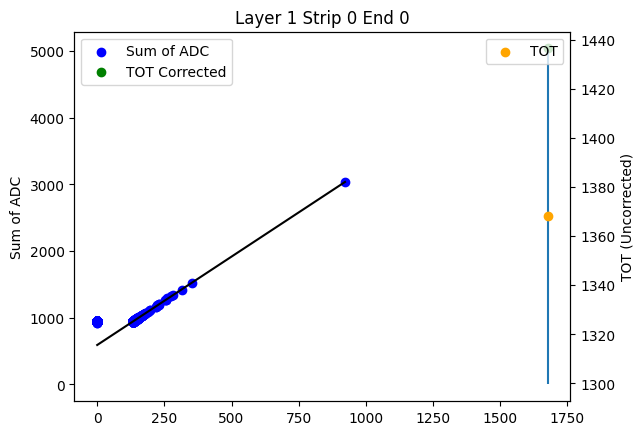

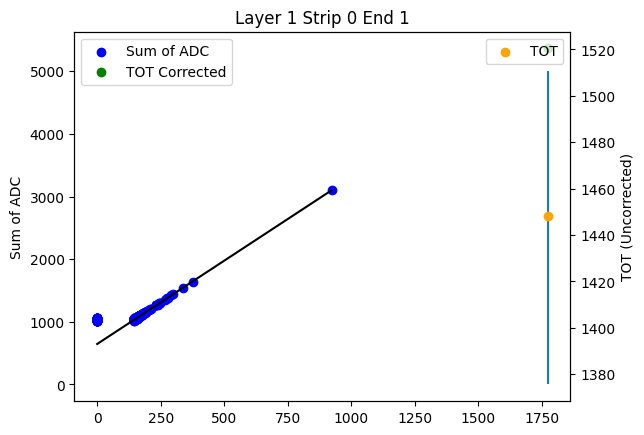

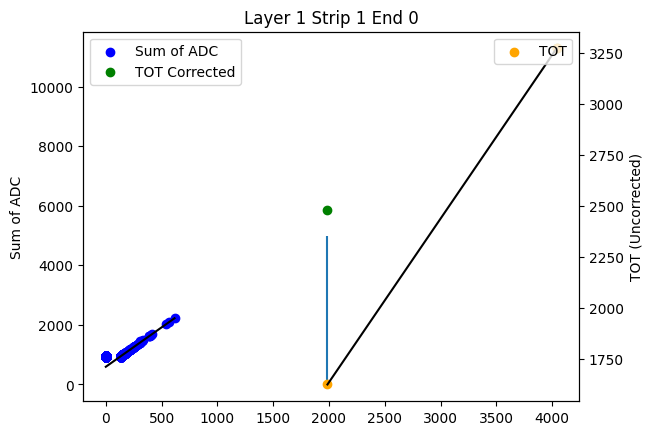

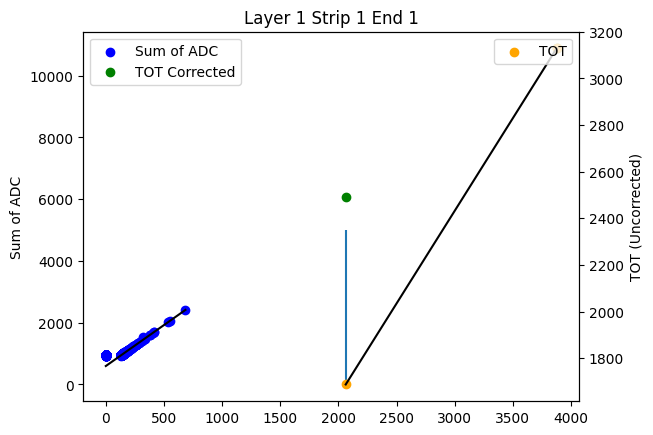

In [9]:
def get_Tc_index(row, end):
    Tc_index = -1
    for i in range(0,8):
        if bool(row["tot_comp_"+str(i)+"_end"+str(end)]):
            Tc_index = i
    return Tc_index
    
def get_TOT(row, end):
    i = get_Tc_index(row, end)
        
    return int(row["tot_"+str(i)+"_end"+str(end)])

#Set to true if you want to save the plots
savePlots = True
#Set to true if you want to save a new .csv calibration file
makeCSV = True
csvFilename = "mc_v6_tot_calibration.csv"

if makeCSV:
    f = open(csvFilename, "w")
    f.write("layer,strip,end,adc_fit_k,adc_fit_m,tot_fit_k,tot_fit_m\n")

for layer in range(1,20):
    for strip in range(0,12):
        for end in [0,1]:
            
            events = mcdata.loc[mcdata['layer'] == layer].loc[mcdata['strip'] == strip]
        
            if events.shape[0] == 0:
                continue
            
            sum_adc = []
            tot = []
            
            truth_vpeak_adc = []
            truth_vpeak_tot = []
            
            for index, row in events.iterrows():
                #If TOT is below the TOT threshold, use only ADC data
                
                if get_Tc_index(row,end) != -1:
                    tot.append(get_TOT(row,end))
                    truth_vpeak_tot.append(row["truth_vpeak_end"+str(end)])
                else:
                    sum_adc.append(row["adc_sum_end"+str(end)])
                    truth_vpeak_adc.append(row["truth_vpeak_end"+str(end)])
            
            #Do not fit to all the points near the pedestal
            truth_vpeak_adc_filtered = []
            sum_adc_filtered = []
            for i in range(0,len(sum_adc)):
                if sum_adc[i] > 1200:
                    sum_adc_filtered.append(sum_adc[i])
                    truth_vpeak_adc_filtered.append(truth_vpeak_adc[i])
            
            #Make a fit to the sumADC values
            adcfit = np.polyfit(truth_vpeak_adc_filtered, sum_adc_filtered, 1)

            #Only keep TOT values before saturation
            truth_vpeak_tot_filtered = []
            tot_filtered = []
            for i in range(0,len(tot)):
                if tot[i] < 4000:
                    truth_vpeak_tot_filtered.append(truth_vpeak_tot[i])
                    tot_filtered.append(tot[i])
            
            #Make a fit to the TOT values
            totfit = np.polyfit(truth_vpeak_tot_filtered, tot_filtered, 1)
            

            if makeCSV:
                f.write(str(layer)+","+str(strip)+","+str(end)+","+str(adcfit[0])+","+str(adcfit[1])+","+str(totfit[0])+","+str(totfit[1])+"\n")
            
            TOTvtresh = min(truth_vpeak_tot) #In units of mV
        
            if savePlots:
                fig, ax1 = plt.subplots()
                ax2 = ax1.twinx()
                    
                ax1.scatter(truth_vpeak_adc,sum_adc, label="Sum of ADC", color="blue")
                ax2.scatter(truth_vpeak_tot, tot, label="TOT", color="orange")
                
                xadc = np.linspace(0,max(truth_vpeak_adc_filtered))
                ax1.vlines(TOTvtresh, 0, 5000)
                ax1.plot(xadc,[x*adcfit[0]+adcfit[1] for x in xadc], color="black")
                
                xtot = np.linspace(TOTvtresh, max(truth_vpeak_tot))
                ax2.plot(xtot, [x*totfit[0]+totfit[1] for x in xtot], color="black")
                
                tot_corrected = [(x-totfit[1])/totfit[0]*adcfit[0]+adcfit[1] for x in tot]
                
                ax1.scatter(truth_vpeak_tot,tot_corrected,label="TOT Corrected", color="green")
                
                ax1.legend(loc=0)
                ax2.legend(loc=1)
                plt.xlabel("Truth peak voltage [mV]")
                ax1.set_ylabel("Sum of ADC")
                ax2.set_ylabel("TOT (Uncorrected)")
                plt.title("Layer " + str(layer) + " Strip " + str(strip) + " End " + str(end))
                plt.savefig("plots/mctot_layer_" + str(layer) + "_strip_" + str(strip) + "_end_" + str(end), format="pdf")

if makeCSV:
    f.close()